## Importation des librairies

In [ ]:
! pip install arch
! pip install numpy 
! pip install matplotlib
! pip install scikit-learn

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm

## Echantillonnage des données simulées selon un modèle GARCH(1,1)  

## Metropolis sampler

## Echantionnage avec l'algorithme Metropolis-Hasting  


Nous présentons deux fonctions Metropolis permettant de générer un échantillon en se basant sur l'algorithme Metropolis-Hastings. La première fonction, metropolis, utilise un algorithme MCMC adaptatif, tandis que la seconde, metropolis2, utilise une marche aléatoire avec une variance adaptative.

## Ordinary MCMC

Nous commençons par une première simulation de 3000 itérations en utilisant la fonction `metropolis2.

In [292]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 3000

# Génération d'échantillons à partir des donées simulées
echant_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[1]
accep_rate_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[0]

# Génération d'échantillons à partir des donées réelles
echant_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[1]
accep_rate_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[0]

## Visualisation de l'évolution des paramètres

In [ ]:
## Visualisation de l'évolution des paramètres à partir des données simulées 

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(2001), echant_sim[1000:, 0])
axs[0].set_ylabel('w1')
axs.grid()
axs[1].plot(range(2001), echant_sim[1000:, 1])
axs[1].set_ylabel('w2')
axs.grid()
axs[2].plot(range(2001), echant_sim[1000:, 2])
axs[2].set_ylabel('w3')
axs.grid()
plt.tight_layout()
plt.show()

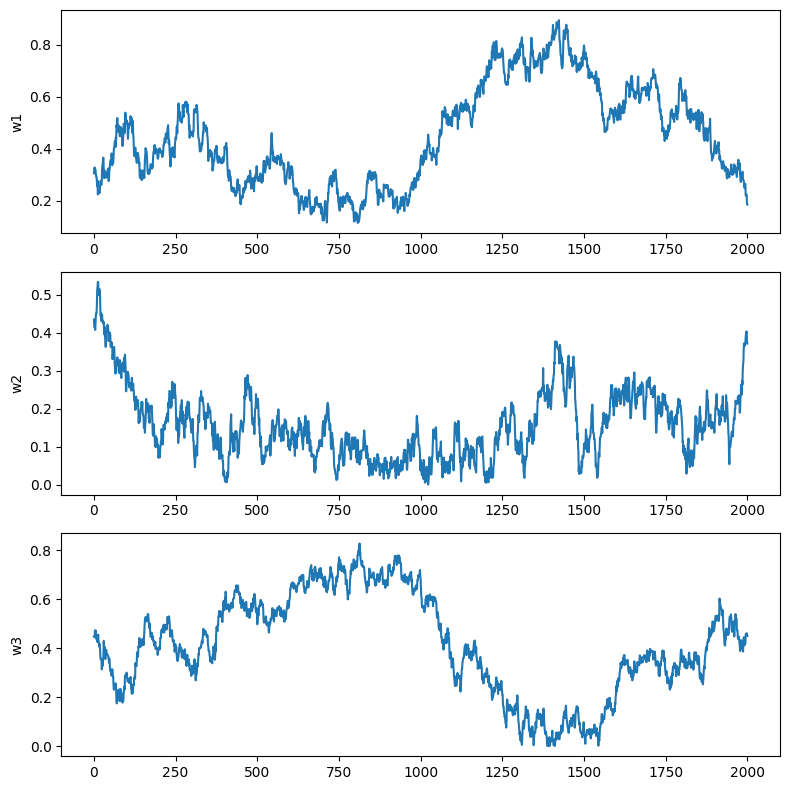

In [296]:
## Visualisation de l'évolution des paramètres à partir des données réelles 

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(2001), echant_reel[1000:, 0])
axs[0].set_ylabel('w1')
axs[1].plot(range(2001), echant_reel[1000:, 1])
axs[1].set_ylabel('w2')
axs[2].plot(range(2001), echant_reel[1000:, 2])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

In [ ]:
def confidence_intervals(mean, se, z_value=1.96):
    lower_bound = mean - z_value * se
    upper_bound = mean + z_value * se
    return lower_bound, upper_bound

def stat_descrip(echant):
    # Calcul des moyennes
    mean_o1 = np.mean(echant[:,0])
    mean_o2 = np.mean(echant[:,1])
    mean_o3 = np.mean(echant[:,2])

    # Calcul des erreurs standards empiriques
    se_o1 = np.std(echant[:,0]) / np.sqrt(len(echant[:,0]))
    se_o2 = np.std(echant[:,1]) / np.sqrt(len(echant[:,1]))
    se_o3 = np.std(echant[:,2]) / np.sqrt(len(echant[:,2]))

    # Calcul des intervalles de confiance à 95%
    ci_o1 = confidence_intervals(mean_o1, se_o1)
    ci_o2 = confidence_intervals(mean_o2, se_o2)
    ci_o3 = confidence_intervals(mean_o3, se_o3)

    # Affichage des résultats
    print("La moyenne de omega1 est autour :", mean_o1)
    print("L'intervalle de confiance de omega1 est donné par :", ci_o1)
    print("La moyenne de omega2 est autour :", mean_o2)
    print("L'intervalle de confiance de omega1 est donné par :", ci_o2)
    print()
    print("La moyenne de omega3 est autour :", mean_o3)
    print("L'intervalle de confiance de omega3 est donné par :", ci_o3)

stat_descrip(echant_sim)
stat_descrip(echant_reel)


## ZV-MCMC : First Order Control Variates

In [297]:
def calcul_z(omega_1, omega_2, omega_3, h, r, sigma):
    T = len(h)
    z_1 = omega_1 / (2 * sigma ** 2)
    z_2 = omega_2 / (2 * sigma ** 2)
    z_3 = omega_3 / (2 * sigma ** 2)
    
    for t in range(1,T):
        dht_domega1 = (1 - omega_3 ** (t-1)) / (1 - omega_3)
        z_1 += 0.25 * (1/h[t]) * dht_domega1 - int((r[t] ** 2 / h[t]**2)) * dht_domega1
        dht_domega2 = np.array([np.sum([w_i**(t-2-i) * r[i]**2 for i in range(t-1)]) for w_i in omega_2])
        z_2 += 0.25 * (1/h[t]) * dht_domega2 - r[t] ** 2 / h[t]**2 * dht_domega2
        dht_domega3 = np.array([np.sum([w_i**(t-2-i) * h[i]**2 for i in range(t-1)]) for w_i in omega_3])
        z_3 += 0.25 * (1/h[t]) * dht_domega3 - (r[t] ** 2 / h[t]) * dht_domega3
    return np.column_stack([z_1, z_2, z_3])

In [303]:
# Les variables de contrôle pour les données simulées

var_sim = np.var(y[:100], ddof=0)
CV1_sim = calcul_z(echant_sim[:,0], echant_sim[:,1], echant_sim[:,2], h[:100], y[:100], var_sim)


# Les variables de contrôle pour les données réelles 

omega1 = echant_reel[:,0].mean()
omega2 = echant_reel[:,1].mean()
omega3 = echant_reel[:,2].mean()

h_reel = np.zeros(len(r[:100])) 

# On estime la variance conditionnelle des données réelles en estimant les omegas par les moyennes empiriques de l'échantillon généré
for t in range(1,len(r[:100])) :
    h_reel[t] = omega1 + omega2 * h_reel[t-1] + omega3 * r[t-1]**2

var_reel = np.var(r[:100], ddof=0)
CV1_reel = calcul_z(echant_reel[:,0], echant_reel[:,1], echant_reel[:,2], h_reel, r[:100], var_reel)

In [ ]:
def enlever_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    # Définition des limites
    limite_inferieure = Q1 - 10 * IQR
    limite_superieure = Q3 + 10 * IQR
    donnees_sans_outliers = np.copy(data)
    for i in range(1, len(data)):
        if (data[i] < limite_inferieure).any() or (data[i] > limite_superieure).any():
            donnees_sans_outliers[i] = donnees_sans_outliers[i - 1]
    return donnees_sans_outliers

## Définition des omega-tildes

In [ ]:

# Les variables de contrôle pour les données simulées

# omega_current = np.array([0.05,0.244,0.598])
# var = [100,100,100]
# n_iter = 10000

# omega_nv_sim = metropolis2 (y, omega_current, n_iter, var, Sigma_opt_sim)[1]
# CV1_nv_sim = calcul_z(omega_nv_sim[:,0], omega_nv_sim[:,1], omega_nv_sim[:,2], h[:100], y[:100], var_sim)


def combi_omega(k, echant_sim, CV1_sim, CV1_nv_sim):

    model = sm.OLS(echant_sim[:,k], CV1_sim) # CV1_sim = sm.add_constant(CV1_sim)
    results = model.fit(cov_type='HC3')
    coeff_opt = results.params # CV1_nv_sim1 = np.insert(CV1_nv_sim, 0, 1, axis=1)
    combi = np.dot(coeff_opt, CV1_nv_sim.transpose())
    print(results.summary())
    return combi


# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1 = combi_omega(0, echant_sim, CV1_sim, CV1_nv_sim)
omega_tilde_1 = omega_nv_sim[:,0] - combi_omega1
omega_tilde_1ss = enlever_outliers(omega_tilde_1)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2 = combi_omega(1, echant_sim, CV1_sim, CV1_nv_sim)
omega_tilde_2 = omega_nv_sim[:,1] - combi_omega2
omega_tilde_2ss = enlever_outliers(omega_tilde_2)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3 = combi_omega(2, echant_sim, CV1_sim, CV1_nv_sim)
omega_tilde_3 = omega_nv_sim[:,2] - combi_omega3
omega_tilde_3ss = enlever_outliers(omega_tilde_3)


In [375]:
# Les variables de contrôle pour les données réelles

omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 10000

omega_nv_reel = metropolis2 (r, omega_current, n_iter, var, Sigma_opt_reel)[1]
CV1_nv_reel = calcul_z(omega_nv_reel[:,0], omega_nv_reel[:,1], omega_nv_reel[:,2], h_reel[:100], r[:100], var_reel)

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_reel = combi_omega(0, echant_reel, CV1_reel, CV1_nv_reel)
omega_tilde_1_reel = omega_nv_reel[:,1] - combi_omega1_reel
omega_tilde_1ss_reel = enlever_outliers(omega_tilde_1_reel)

# ------------------------------------- Omega_2----------------------------------------------------------------
combi_omega2_reel = combi_omega(1, echant_reel, CV1_reel, CV1_nv_reel)
omega_tilde_2_reel = omega_nv_reel[:,1] - combi_omega2_reel
omega_tilde_2ss_reel = enlever_outliers(omega_tilde_2_reel)

# ------------------------------------- Omega_3----------------------------------------------------------------
combi_omega3_reel = combi_omega(2, echant_reel, CV1_reel, CV1_nv_reel)
omega_tilde_3_reel = omega_nv_reel[:,1] - combi_omega3_reel
omega_tilde_3ss_reel = enlever_outliers(omega_tilde_3_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              9571.
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                        0.00
Time:                        18:36:04   Log-Likelihood:                          1958.9
No. Observations:                3001   AIC:                                     -3912.
Df Residuals:                    2998   BIC:                                     -3894.
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## Visualatisation des trajectoires des omegas après ZV-MCMC d'ordre 1

Pour les données simulées

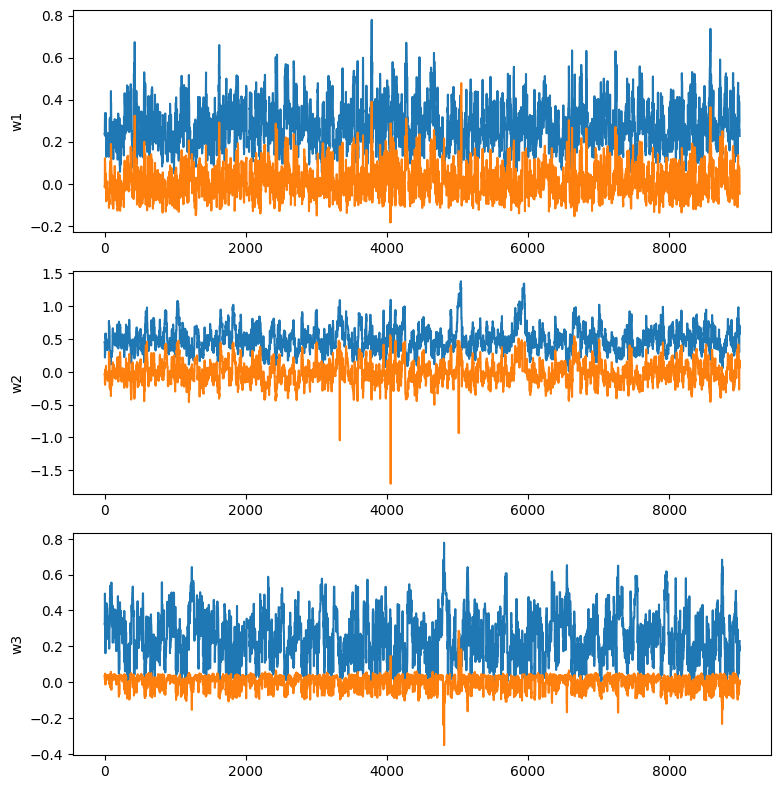

In [374]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), omega_nv_sim[:,0][1000:])
axs[0].plot(range(9001), omega_tilde_1ss[1000:])
axs[0].set_ylabel('w1')
axs[1].plot(range(9001), omega_nv_sim[:,1][1000:])
axs[1].plot(range(9001), omega_tilde_2ss[1000:])
axs[1].set_ylabel('w2')
axs[2].plot(range(9001), omega_nv_sim[:,2][1000:])
axs[2].plot(range(9001), omega_tilde_3ss[1000:])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

Pour les données réelles : 

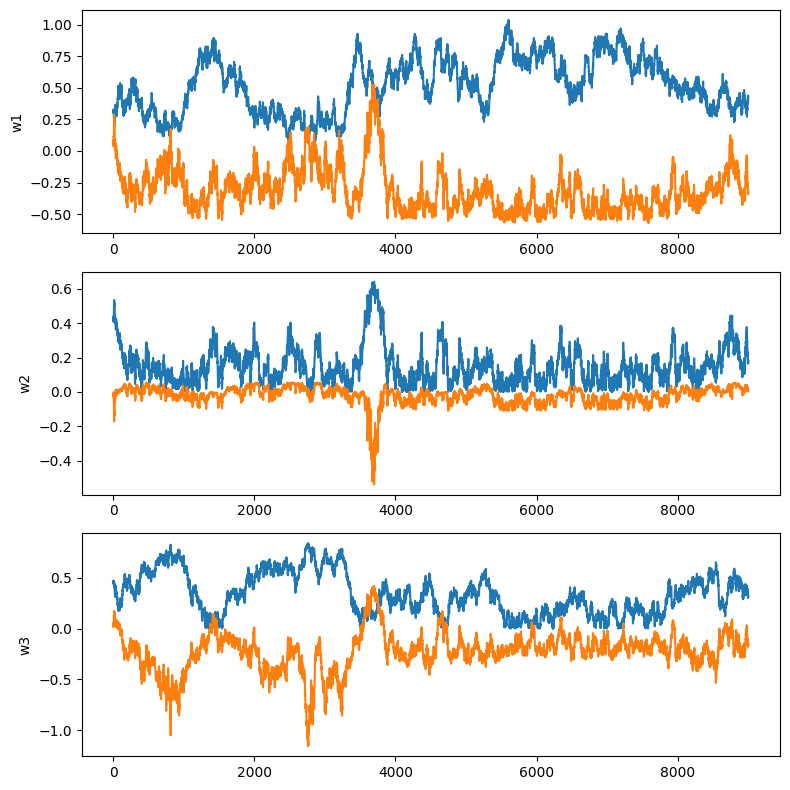

In [376]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), omega_nv_reel[:,0][1000:])
axs[0].plot(range(9001), omega_tilde_1ss_reel[1000:])
axs[0].set_ylabel('w1')
axs[1].plot(range(9001), omega_nv_reel[:,1][1000:])
axs[1].plot(range(9001), omega_tilde_2ss_reel[1000:])
axs[1].set_ylabel('w2')
axs[2].plot(range(9001), omega_nv_reel[:,2][1000:])
axs[2].plot(range(9001), omega_tilde_3ss_reel[1000:])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

## ZV-MCMC : Second Order Control Variates

In [377]:

def control_variates_2 (x,z):
    """
    Args:
        x (np.array): échantillon de paramètres (omega1, omega2, omega3)
        z (np.array): échantillon de variables de contrôle d'ordre 1 (z1,z2,z3)

    Returns:
        np.array: un échantillon de 9 variables de contrôle, ZV-MCMC d'ordre 2
    """
    i = np.ones(z.shape)
    u = z*x -0.5*i
    v1 = x[:,1]*z[:,0] + x[:,0]*z[:,1]
    v2 = x[:,2]*z[:,0] + x[:,0]*z[:,2]
    v3 = x[:,2]*z[:,1] + x[:,1]*z[:,2]
    v = np.column_stack((v1, v2, v3))
    vT = v.transpose()
    uT = u.transpose()
    zT = z.transpose()
    zTuTvT = np.concatenate((zT, uT, vT), axis = 0)

    # CV2 est un échantillon de même taille que x et z de 9-uplets ; Pour ZV-MCMC de degré 2 on a 9 variables de contrôles
    # Une colonne de CV2 est une variable de contôle 
    CV2 = zTuTvT.transpose()

    return CV2


First stage : Une première régression pour chaque paramètre omega_i pour déterminer les coefficients optimaux de chacune des 9 variables de contrôle.

In [378]:

CV2_sim = control_variates_2 (echant_sim,CV1_sim)

CV2_nv_sim = control_variates_2 (omega_nv_sim, CV1_nv_sim)

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_d2 = combi_omega(0, echant_sim, CV2_sim, CV2_nv_sim)
omega_tilde_1_d2 = omega_nv_sim[:,0] - combi_omega1_d2
omega_tilde_1ss_d2 = enlever_outliers(combi_omega1_d2)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2_d2 = combi_omega(1, echant_sim, CV2_sim, CV2_nv_sim)
omega_tilde_2_d2 = omega_nv_sim[:,1] - combi_omega2_d2
omega_tilde_2ss_d2 = enlever_outliers(omega_tilde_2_d2)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3_d2 = combi_omega(2, echant_sim, CV2_sim, CV2_nv_sim)
omega_tilde_3_d2 = omega_nv_sim[:,2] - combi_omega3_d2
omega_tilde_3ss_d2 = enlever_outliers(omega_tilde_3_d2)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.132e+05
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                        0.00
Time:                        19:41:58   Log-Likelihood:                          9954.8
No. Observations:                3001   AIC:                                 -1.989e+04
Df Residuals:                    2992   BIC:                                 -1.984e+04
Df Model:                           9                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/home/onyxia/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '


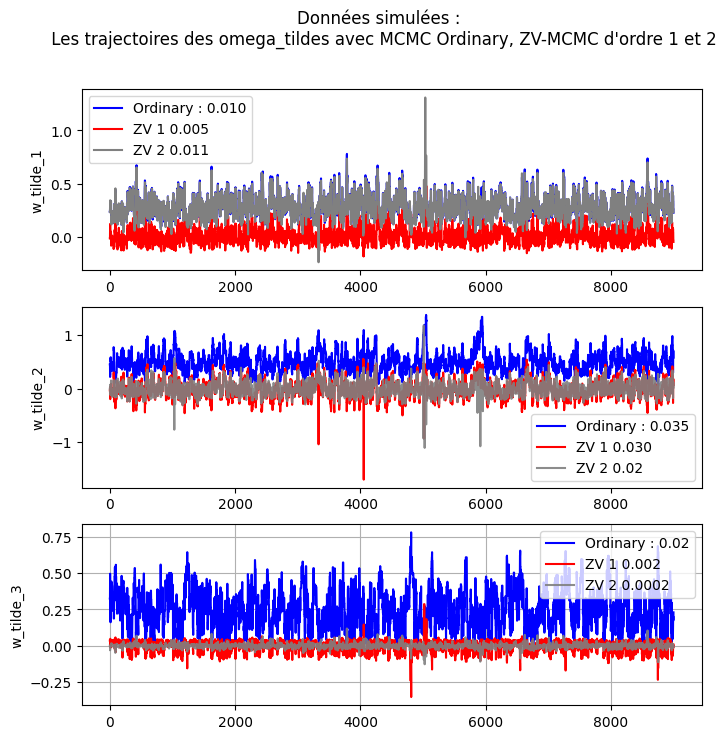

In [419]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), omega_nv_sim[:,0][1000:], label="Ordinary : {:.3f}".format(np.var(omega_nv_sim[1000:,0])), color = 'blue')
axs[0].plot(range(9001), omega_tilde_1ss[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_1ss[1000:])), color = 'red')
axs[0].plot(range(9001), omega_tilde_1ss_d2[1000:], label="ZV 2 {:.3f}".format(np.var(omega_tilde_1ss_d2[1000:])), color = 'grey')
axs[0].set_ylabel('w_tilde_1')
axs[0].legend()

axs[1].plot(range(9001), omega_nv_sim[:,1][1000:], label="Ordinary : {:.3f}".format(np.var(omega_nv_sim[1000:,1])), color = 'blue')
axs[1].plot(range(9001), omega_tilde_2ss[1000:],  label="ZV 1 {:.3f}".format(np.var(omega_tilde_2ss[1000:])),  color = 'red')
axs[1].plot(range(9001), omega_tilde_2ss_d2[1000:], label="ZV 2 {:.2f}".format(np.var(omega_tilde_2ss_d2[1000:])), color = 'grey')
axs[1].set_ylabel('w_tilde_2')
axs[1].legend()

axs[2].plot(range(9001), omega_nv_sim[:,2][1000:], label="Ordinary : {:.2f}".format(np.var(omega_nv_sim[1000:,2])), color = 'blue')
axs[2].plot(range(9001), omega_tilde_3ss[1000:],  label="ZV 1 {:.3f}".format(np.var(omega_tilde_3ss[1000:])), color = 'red')
axs[2].plot(range(9001), omega_tilde_3ss_d2[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_3ss_d2[1000:])), color = 'grey')
axs[2].set_ylabel('w_tilde_3')
axs[2].legend()

plt.suptitle("Données simulées : \n Les trajectoires des omega_tildes avec MCMC Ordinary, ZV-MCMC d'ordre 1 et 2")
plt.grid()
plt.show()

In [389]:
CV2_reel = control_variates_2 (echant_reel,CV1_reel)

CV2_nv_reel = control_variates_2 (omega_nv_reel, CV1_nv_reel)

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_d2_reel = combi_omega(0, echant_reel, CV2_reel, CV2_nv_reel)
omega_tilde_1_d2_reel = omega_nv_reel[:,0] - combi_omega1_d2_reel
omega_tilde_1ss_d2_reel = enlever_outliers(omega_tilde_1_d2_reel)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2_d2_reel = combi_omega(1, echant_reel, CV2_reel, CV2_nv_reel)
omega_tilde_2_d2_reel = omega_nv_reel[:,1] - combi_omega2_d2_reel
omega_tilde_2ss_d2_reel = enlever_outliers(omega_tilde_2_d2_reel)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3_d2_reel = combi_omega(2, echant_reel, CV2_reel, CV2_nv_reel)
omega_tilde_3_d2_reel = omega_nv_reel[:,2] - combi_omega3_d2_reel
omega_tilde_3ss_d2_reel = enlever_outliers(omega_tilde_3_d2_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.042e+06
Date:                Sun, 28 Apr 2024   Prob (F-statistic):                        0.00
Time:                        19:58:56   Log-Likelihood:                          9966.7
No. Observations:                3001   AIC:                                 -1.992e+04
Df Residuals:                    2992   BIC:                                 -1.986e+04
Df Model:                           9                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

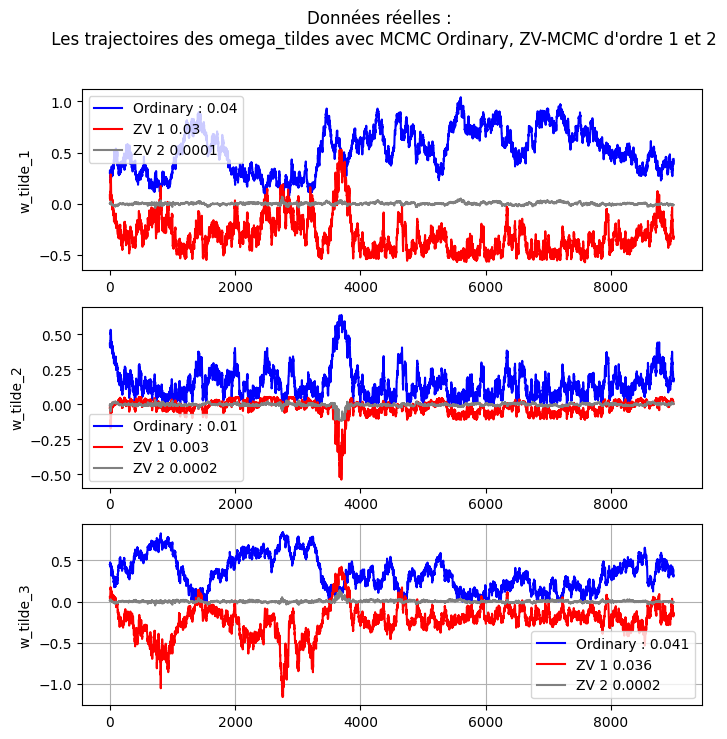

In [409]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), omega_nv_reel[1000:,0], label="Ordinary : {:.2f}".format(np.var(omega_nv_reel[1000:,0])), color = 'blue')
axs[0].plot(range(9001), omega_tilde_1ss_reel[1000:], label="ZV 1 {:.2f}".format(np.var(omega_tilde_1ss_reel[1000:])), color = 'red')
axs[0].plot(range(9001), omega_tilde_1ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_1ss_d2_reel[1000:])), color = 'grey')
axs[0].set_ylabel('w_tilde_1')
axs[0].legend()

axs[1].plot(range(9001), omega_nv_reel[1000:,1], label="Ordinary : {:.2f}".format(np.var(omega_nv_reel[1000:,1])), color = 'blue')
axs[1].plot(range(9001), omega_tilde_2ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_2ss_reel[1000:])),  color = 'red')
axs[1].plot(range(9001), omega_tilde_2ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_2ss_d2_reel[1000:])), color = 'grey')
axs[1].set_ylabel('w_tilde_2')
axs[1].legend()

axs[2].plot(range(9001), omega_nv_reel[:,2][1000:], label="Ordinary : {:.3f}".format(np.var(omega_nv_reel[1000:,2])), color = 'blue')
axs[2].plot(range(9001), omega_tilde_3ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_3ss_reel[1000:])), color = 'red')
axs[2].plot(range(9001), omega_tilde_3ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_3ss_d2_reel[1000:])), color = 'grey')
axs[2].set_ylabel('w_tilde_3')
axs[2].legend()

plt.suptitle("Données réelles : \n Les trajectoires des omega_tildes avec MCMC Ordinary, ZV-MCMC d'ordre 1 et 2")
plt.grid()
plt.show()

## Approche naïve : une seule régression

Second stage : génération des échantillons omega_tilde 

Maintenant qu'on a récupéré les coefficients optimaux des variables de contrôle avec une régression linéaire, nous générons un échantillon omega1_tilde, omega2_tilde et omega3_tilde tel que : 

    omegai_tilde = omega_i + la combinaison linéaire des variables de contrôle pondérées par les coefficients trouvés par la régression.
Cette combinaison est exactement la prédiction du modèle.

## Approche LASSO : CODE NON TESTE

In [431]:
def cross_validation(X, Y, lamb):

    k = 10  # Nombre de plis
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Effectuer la validation croisée
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lasso = Lasso(alpha=lamb)
        lasso.fit(X_train_scaled, y_train)
        predictions = lasso.predict(X_test_scaled)

        # Calculer l'erreur quadratique moyenne (MSE) des prédictions
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculer la moyenne des scores MSE sur les plis
    average_mse = np.mean(mse_scores)
    
    return average_mse

def lambda_etoile (X,Y):
    MSE = []
    LAM  = np.linspace(0,100,1000) 
    for lamb in LAM :
        MSE.append(cross_validation(X,Y,lamb))
    i = MSE.index(MSE.min())
    return LAM[i]


def beta_LASSO (X,Y, lamb) :
    lasso = Lasso(alpha=lamb)
    lasso.fit(X, Y)
    return lasso.coef_

lam_sim = lambda_etoile (CV2_sim,echant_sim[:,0])
beta_LASSO_sim = beta_LASSO (X,Y, lam_sim)

def reg_penal(X,Y,beta_LASSO):
    var = []
    
    for i in len(beta_LASSO) :
        if beta_LASSO[i] != 0 :
            var.append(i)

    model = LinearRegression()
    model.fit(X[:,var], Y)

    return Y +  model.predict(X) # nos omega_tilde


/home/onyxia/.local/lib/python3.10/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/onyxia/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/onyxia/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.841e-01, tolerance: 2.566e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_f

NameError: name 'mean_squared_error' is not defined